In [3]:
import xarray as xr
import os
import numpy as np
from satpy import Scene
import pyresample.geometry
import warnings 
import pandas as pd
from tqdm import tqdm
import glob

In [21]:
filelist = glob.glob(os.path.join('../../../data/observations/raw/satellite/modis/mod29_swath/', '*.hdf'))
filelist
ds = xr.open_dataset(filelist[0], engine='netcdf4')
ds

print(filelist)

from collections import defaultdict

filelist_by_day = {}

for f in filelist:

    day = f.split('/')[-1].split('.')[1][5:]
    if day not in filelist_by_day:
        filelist_by_day[day] = []

    time_of_day = int(f.split('/')[-1].split('.')[2])

    if (time_of_day > 800) and (time_of_day < 1800):

        filelist_by_day[day].append(f)

sorted(filelist_by_day)
filelist_by_day

['../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024120.0835.061.2024120191356.hdf', '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024104.0915.061.2024104191734.hdf', '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024113.0710.061.2024113191923.hdf', '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024120.1330.061.2024121012514.hdf', '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024119.0615.061.2024119192512.hdf', '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024092.1550.061.2024093012814.hdf', '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024094.1710.061.2024095011647.hdf', '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024099.1540.061.2024100012942.hdf', '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024102.1250.061.2024103013535.hdf', '../../../data/observations/raw/satellite/modis/mod29_swath/MOD

{'120': ['../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024120.0835.061.2024120191356.hdf',
  '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024120.1330.061.2024121012514.hdf',
  '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024120.1510.061.2024121012417.hdf',
  '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024120.1505.061.2024121012458.hdf',
  '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024120.1150.061.2024120191347.hdf',
  '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024120.1155.061.2024120191414.hdf',
  '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024120.1015.061.2024120191421.hdf',
  '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024120.1645.061.2024121012453.hdf'],
 '104': ['../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024104.0915.061.2024104191734.hdf',
  '../../../data/observations/r

(array([1.1000e+01, 2.3000e+01, 1.2800e+02, 4.9100e+02, 1.5640e+03,
        3.3220e+03, 4.2780e+03, 7.4010e+03, 1.4781e+04, 2.5338e+04,
        2.5484e+04, 2.7873e+04, 3.3648e+04, 3.5674e+04, 3.3192e+04,
        3.8431e+04, 3.2242e+04, 2.4243e+04, 2.0570e+04, 2.5041e+04,
        3.0344e+04, 4.3600e+04, 4.3077e+04, 3.6567e+04, 2.5644e+04,
        1.7081e+04, 1.3354e+04, 1.1346e+04, 9.6030e+03, 7.0170e+03,
        4.5760e+03, 4.3830e+03, 5.3290e+03, 7.9170e+03, 8.8150e+03,
        7.2760e+03, 6.8070e+03, 6.7100e+03, 6.9670e+03, 6.1090e+03,
        9.1650e+03, 1.1145e+04, 2.2050e+03, 5.6400e+02, 9.5000e+01,
        4.8000e+01, 1.8600e+02, 2.2100e+02, 3.4800e+02, 9.1000e+01]),
 array([248.76  , 249.2886, 249.8172, 250.3458, 250.8744, 251.403 ,
        251.9316, 252.4602, 252.9888, 253.5174, 254.046 , 254.5746,
        255.1032, 255.6318, 256.1604, 256.689 , 257.2176, 257.7462,
        258.2748, 258.8034, 259.332 , 259.8606, 260.3892, 260.9178,
        261.4464, 261.975 , 262.5036, 263.0322

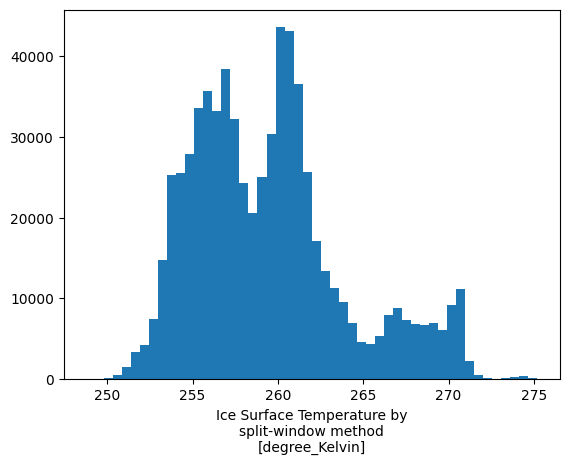

In [28]:
ds['Ice_Surface_Temperature'].where((ds['Ice_Surface_Temperature_Pixel_QA'] == 0) & (ds['Ice_Surface_Temperature'] > 100)).plot.hist(bins=50)

In [30]:
import os
from tqdm import tqdm
import xarray as xr
import numpy as np
from scipy.ndimage import zoom

# Correct, modern pyresample imports
from pyresample import geometry, image

list_of_ds = []

# Assuming 'filelist' is a list of your MOD29 .hdf file paths
# filelist = ['MOD29.A2022095.0000.061.2022095134100.hdf'] 

for file in tqdm(filelist):
    day =  f.split('/')[-1].split('.')[1][5:]
    time_of_day = int(f.split('/')[-1].split('.')[2])
    output_filename = file.replace('.hdf', '_resampled.nc')
    #print(f"Processing file: {file} -> {output_filename}")
    #continue
    # if os.path.exists(output_filename):
    #     #print(f"File {output_filename} already exists. Skipping...")
    #     continue

    try:
        # 1. Manually open the HDF5 file using xarray
        ds = xr.open_dataset(file, engine='netcdf4')
        
        # Upscale coordinates to match data resolution
        lon_low_res = ds['Longitude'].values
        lat_low_res = ds['Latitude'].values
        ist = ds['Ice_Surface_Temperature'].where((ds['Ice_Surface_Temperature_Pixel_QA'] == 0) & (ds['Ice_Surface_Temperature'] > 150))
        
        zoom_y = ist.shape[0] / lat_low_res.shape[0]
        zoom_x = ist.shape[1] / lon_low_res.shape[1]

        lon_high_res = zoom(lon_low_res, (zoom_y, zoom_x), order=1)
        lat_high_res = zoom(lat_low_res, (zoom_y, zoom_x), order=1)

        # 2. Define the source and target geometries (this part is unchanged)
        swath_def = geometry.SwathDefinition(lons=lon_high_res, lats=lat_high_res)
        
        area_def = geometry.create_area_def(
            area_id='mygrid',
            projection={'proj': 'latlong', 'lon_0': 0},
            width=2000,
            height=1200,
            area_extent=(-20, 70, 20, 85)
        )

        # --- KEY CHANGE IS HERE: Use the modern Pyresample API ---

        # 3a. Create an image container for the data using the 'nearest' algorithm.
        #     This bundles the data and its geometry together.
        swath_con = image.ImageContainerNearest(
            ist.values,               # The raw data as a numpy array
            swath_def,                # The swath definition we created
            radius_of_influence=2000  # Search radius in meters
        )

        # 3b. Call the .resample() method on the container.
        area_con = swath_con.resample(area_def)
        
        # 3c. Get the resampled data from the result object.
        resampled_data = area_con.image_data
        resampled_data[resampled_data == 0] = np.nan # Often fill_value is 0, convert to NaN

        # 4. Create a new xarray DataArray and save (this part is unchanged)
        lons_grid, lats_grid = area_def.get_lonlats()
        lons = lons_grid.mean(axis=0)
        lats = lats_grid.mean(axis=1)

        resampled_da = xr.DataArray(
            resampled_data,
            dims=('y', 'x'),
            coords={'y': lats, 'x': lons},
            name='ice_surface_temperature'
        )
        
        resampled_da.attrs = ist.attrs
        resampled_da.attrs['comment'] = "Resampled from native MODIS swath to a regular lat/lon grid."

        resampled_da.to_netcdf(output_filename, mode='w')

        list_of_ds.append(resampled_da)
        #print(f"Successfully processed and saved {output_filename}")

    except Exception as e:
        # The error message now includes the file that failed.
        print(f"Failed to process {file}. Error: {e}")

  0%|          | 0/509 [00:00<?, ?it/s]/projekt_agmwend/home_rad/Joshua/micromamba/envs/mamba_josh/lib/python3.12/site-packages/pyresample/image.py:252: FutureWarning: Usage of ImageContainer is deprecated, please use NumpyResamplerBilinear class instead
  super(ImageContainerNearest, self).__init__(image_data, geo_def,
  0%|          | 1/509 [00:00<04:45,  1.78it/s]/projekt_agmwend/home_rad/Joshua/micromamba/envs/mamba_josh/lib/python3.12/site-packages/pyresample/image.py:252: FutureWarning: Usage of ImageContainer is deprecated, please use NumpyResamplerBilinear class instead
  super(ImageContainerNearest, self).__init__(image_data, geo_def,
  0%|          | 2/509 [00:01<04:30,  1.87it/s]/projekt_agmwend/home_rad/Joshua/micromamba/envs/mamba_josh/lib/python3.12/site-packages/pyresample/image.py:252: FutureWarning: Usage of ImageContainer is deprecated, please use NumpyResamplerBilinear class instead
  super(ImageContainerNearest, self).__init__(image_data, geo_def,
  1%|          | 3

In [3]:
list_of_ds = []
from tqdm import tqdm
import glob
import xarray as xr
from dask.distributed import Client, LocalCluster
import pandas as pd

cluster = LocalCluster(
    n_workers=32,
    threads_per_worker=1,
    memory_limit='16GB',
)

client = Client(cluster)
print(client)
nc_files = glob.glob('../../../data/observations/raw/satellite/modis/mod29_swath/*_resampled.nc')
print(nc_files)

for file in tqdm(nc_files):
    ds_ = xr.open_dataset(file, chunks={'x' : 1000, 'y': 600, 'time' : 50}, engine='netcdf4')
    year_str = file.split('/')[-1].split('.')[1][1:5]
    day_str = file.split('/')[-1].split('.')[1][5:]
    time_str = int(file.split('/')[-1].split('.')[2])
    datetime_str = year_str + day_str + f'{time_str:04}'
    datetime = pd.to_datetime(datetime_str, format='%Y%j%H%M')
    ds_['time'] = datetime
    list_of_ds.append(ds_)


/projekt_agmwend/home_rad/Joshua/micromamba/envs/mamba_josh/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33037 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:34475' processes=32 threads=32, memory=476.84 GiB>
['../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024118.2015.061.2024119073749_resampled.nc', '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024113.1515.061.2024114012218_resampled.nc', '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024112.1435.061.2024113011514_resampled.nc', '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024099.1545.061.2024100012801_resampled.nc', '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024118.2155.061.2024119073710_resampled.nc', '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024094.1040.061.2024094193619_resampled.nc', '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024120.0835.061.2024120191356_resampled.nc', '../../../data/observations/raw/satellite/modis/mod29_swath/MOD29.A2024113.1700.061.2024114012219_resampled.nc', '../../../data/obs

100%|██████████| 509/509 [00:06<00:00, 78.51it/s]


In [4]:
ds = xr.concat(list_of_ds, dim='time').sortby('time')

ds_formatted = ds.copy()
ds_formatted = ds_formatted.rename({'x': 'lon', 'y': 'lat'})

ds_formatted
ds_formatted.to_zarr('../../../data/observations/processed/satellite_unified/mod29_swath_unified.zarr', 
           mode='w',
           consolidated=True)

/projekt_agmwend/home_rad/Joshua/micromamba/envs/mamba_josh/lib/python3.12/site-packages/xarray/structure/concat.py:637: UserWarning: No index created for dimension time because variable time is not a coordinate. To create an index for time, please first call `.set_coords('time')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
